# Jeremy notebook for final project

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import k_means
from helpers import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Table segmentation

### Segmentation Helpers 

In [3]:
reduction_factor = 30 #30
table_im_big = cv2.imread("data/train/train_09.jpg")
target_size = (int(table_im_big.shape[1]/reduction_factor),
               int(table_im_big.shape[0]/reduction_factor))
table_im = cv2.resize(table_im_big,target_size)

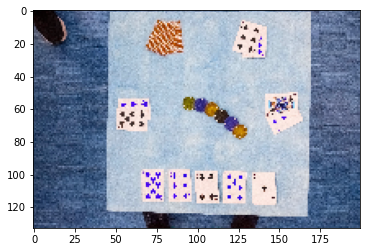

In [89]:
plt.imshow(table_im)

Current image: the shape of image=(26600, 3), the data type=float64.
The current iteration of kmeans is: 0, the average loss is 14551.006353383458.
The current iteration of kmeans is: 10, the average loss is 2720.806783781768.


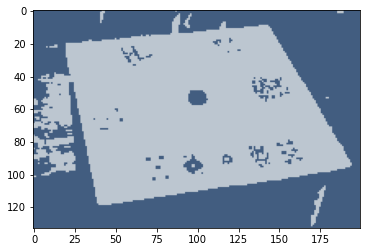

In [5]:
table_smooth = cv2.GaussianBlur(table_im,(0,0),0.7)
table_compressed = k_means.kmean_compression(table_smooth,k=2)
plt.imshow(table_compressed)

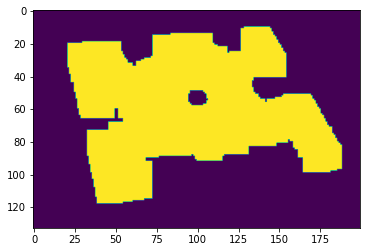

In [7]:
edge_mask = np.zeros(table_compressed.shape[:-1])
edge_mask[(table_compressed > 120)[:,:,0]] = 1
#kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(51,51))
kernel = np.ones((15,15))
edge_mask = cv2.morphologyEx(edge_mask, cv2.MORPH_OPEN, kernel)
plt.imshow(edge_mask)

### Extract table visualization

In [10]:
corners = retrieve_corners_opt(edge_mask)
corners

((11, 145), (96, 188), (117, 39), (20, 21))

(3180, 5010, 3)


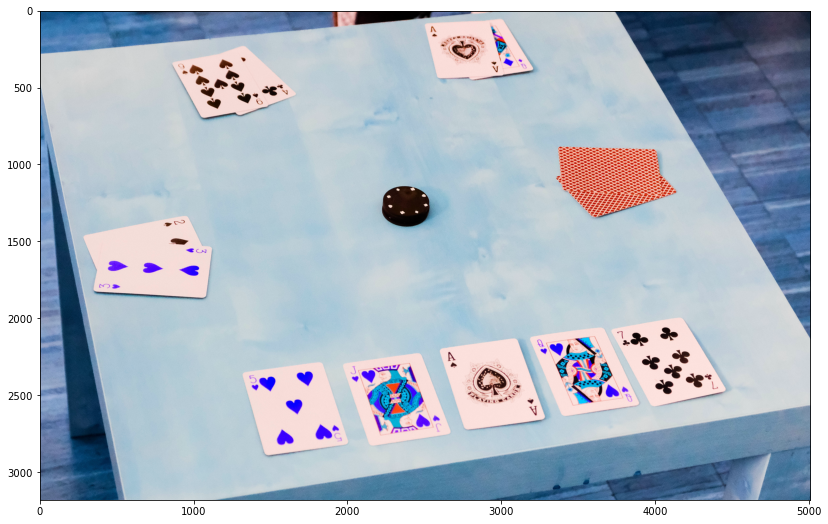

In [11]:
test = extract_table(table_im_big,corners,reduction_factor)
print(test.shape)
fig,ax = plt.subplots(figsize=(16,9))
ax.imshow(test)

## Segmentation pipeline

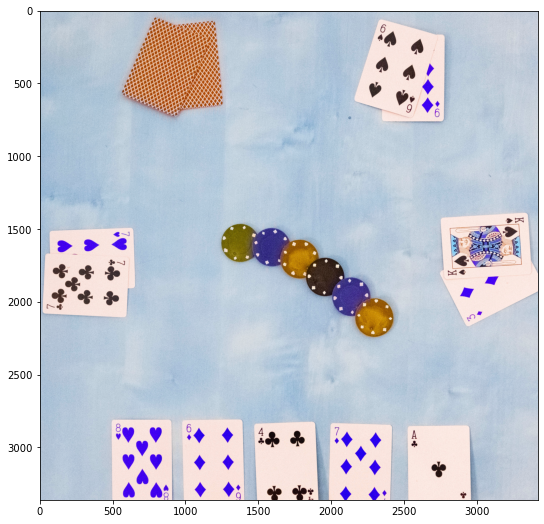

In [101]:
gray_sobel = cv2.cvtColor(sobel_filter(table_im,balance=1), cv2.COLOR_BGR2GRAY)
log = LoG(gray_sobel,sigma=1,tr=20)
### Detect center
kernel = np.ones((7,7))
inverse_log = -log + 1
start_mask = cv2.morphologyEx(inverse_log, cv2.MORPH_OPEN, kernel)
x_center, y_center = start_mask.shape[0]/2,start_mask.shape[1]/2
start_indices = zip(np.where(start_mask == 1)[0],np.where(start_mask == 1)[1])
start = sorted(start_indices,key=lambda l: np.power((l[0]-x_center,l[1]-y_center),2).sum())[0]
### Segment table
kernel = np.ones((2,2))
inverse_log = cv2.morphologyEx(inverse_log, cv2.MORPH_OPEN, kernel)
segmentation = np.zeros(inverse_log.shape,dtype=np.uint8)
for i in iterative_grow(inverse_log,start[0],start[1],0.5):
    segmentation[i[0],i[1]] = 255
corners = retrieve_corners_opt(segmentation)
table_segmentation = extract_table(table_im_big,corners,reduction_factor)
fig,ax = plt.subplots(figsize=(16,9))
ax.imshow(table_segmentation)

## Segmentation Tests

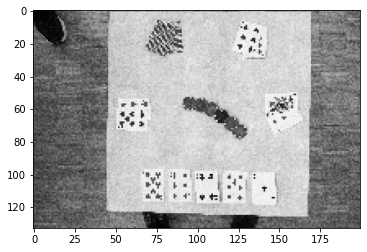

In [4]:
gray = cv2.cvtColor(table_im, cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap="gray")

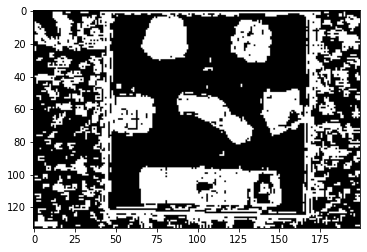

In [5]:
plt.imshow(LoG(table_im,tr=20))

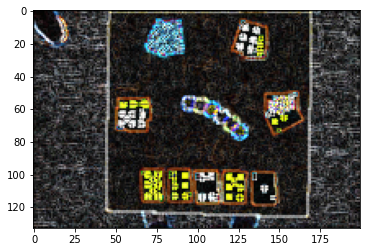

In [6]:
plt.imshow(sobel_filter(table_im,balance=1))

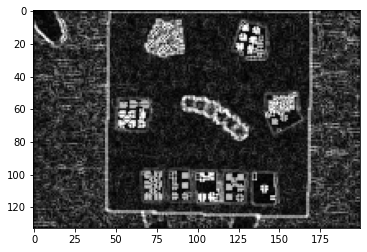

In [7]:
gray = cv2.cvtColor(sobel_filter(table_im,balance=1), cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap="gray")

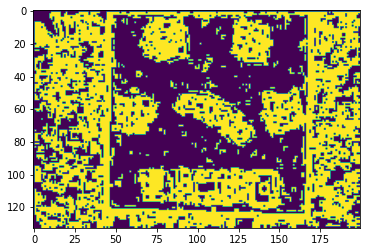

In [8]:
test_log = LoG(gray,sigma=1,tr=20)
plt.imshow(test_log)

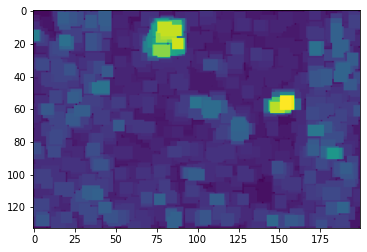

In [10]:
kernel = np.ones((7,7))
start_mask = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
plt.imshow(start_mask)
x_center, y_center = start_mask.shape[0]/2,start_mask.shape[1]/2
start_indices = zip(np.where(start_mask == 1)[0],np.where(start_mask == 1)[1])
start = sorted(start_indices,key=lambda l: np.power((l[0]-x_center,l[1]-y_center),2).sum())[0]

In [67]:
test_segmentation = np.zeros(test_log.shape,dtype=np.uint8)
for i in iterative_grow(-test_log,start[0],start[1],-0.5):
    test_segmentation[i[0],i[1]] = 255

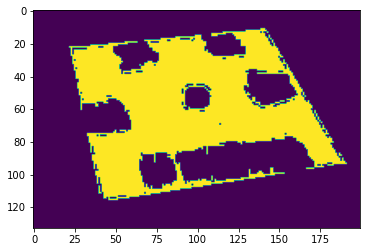

In [68]:
plt.imshow(test_segmentation)

In [70]:
corners = retrieve_corners_opt(test_segmentation)
corners

((13, 143), (93, 191), (111, 40), (22, 22))

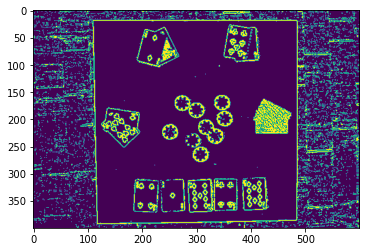

In [48]:
sobel_table = sobel_filter(table_im,balance=1)
edge_mask = np.zeros(sobel_table.shape[:-1])
edge_mask[sobel_table.sum(axis=-1) > 200] = 1
plt.imshow(edge_mask)

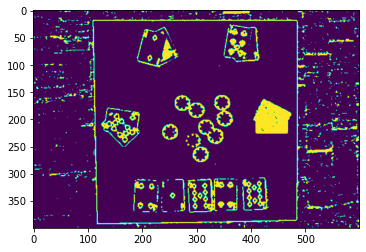

In [49]:
plt.imshow(median_filter(edge_mask,k=3))

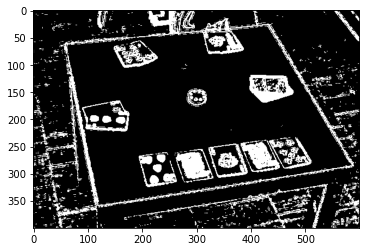

In [47]:
plt.imshow(LoG(table_im,tr=20))